# Probabilistic Graphical Models, SS 2022

In [1]:
import os
import re
import nltk
import shutil
import gensim
import pprint
import random
import zipfile
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from gensim.corpora import Dictionary
from sklearn.datasets import load_files
from nltk.corpus import names, stopwords
from gensim.models.phrases import Phraser
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import sent_tokenize, RegexpTokenizer
from gensim.models import Phrases, CoherenceModel, LdaModel, HdpModel

stop_words = stopwords.words('english')

## 1. Loading and preprocessing the datasets

### 1.1 Load `20NewsGroup` dataset

In [2]:
ARCHIVE_NAME_ORIGINAL = "original.zip"
ARCHIVE_NAME_MODIFIED = "modified.zip"

In [3]:
def load_dataset(archive_name):
    target_dir = 'data/'
    archive_path = os.path.join(target_dir, archive_name)
    if archive_name=="original.zip":        
        path = os.path.join(target_dir, 'original')
    else:
        path = os.path.join(target_dir, 'modified')
       
    print("Decompressing %s" %archive_name)    
    with zipfile.ZipFile(archive_path, 'r') as zip_ref:
        if not os.path.exists(path):
            zip_ref.extractall(target_dir)
        else:
            shutil.rmtree(path)
            zip_ref.extractall(target_dir) 
    
    # Load text files with categories as subfolder names
    # Decode text files, if encoding=None load_files() returns list of bytes
    dataset = load_files(path, load_content=True, encoding='latin1')
    data = dataset.data
    print("Data is decompressed!") 
    
    return data

#### Load '20NewsGroup' dataset in two formats: the original (orig), and a slightly modified (mod) version

In [4]:
nltk.download('wordnet')
nltk.download('omw-1.4')

dataset_original = load_dataset(ARCHIVE_NAME_ORIGINAL)
print('Number of original newsgroup documents: %d\n' % len(dataset_original))

dataset_modified = load_dataset(ARCHIVE_NAME_MODIFIED)
print('Number of modified newsgroup documents: %d' % len(dataset_modified))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Decompressing original.zip
Data is decompressed!
Number of original newsgroup documents: 19997

Decompressing modified.zip
Data is decompressed!
Number of modified newsgroup documents: 18397


### 1.2 Preprocess the datasets

In [5]:
#remove the documents' header
#def remove_text_header(text):
 #   header, blankline, content = text.partition('\n\n')
  #  return content

#remove the documents' footer/signature
#def remove_text_footer(text):
 #   text = text.replace('-', '')        
  #  content, blankline, footer = text.rpartition('\n\n')
   # return content

In [6]:
def preprocess(dataset):  
    min_tokens = 25
    
    # remove document with fewer than 25 tokens
    dataset = [paper for paper in dataset if len(paper.split())>min_tokens]
    
    # remove emails
    dataset = [re.sub('\S*@\S*\s?', '', paper) for paper in dataset] 
        
    # convert to lowercase and split document into tokens
    for i in tqdm(range(len(dataset))):
        # remove punctuation, numbers and tokens that contain numbers
        tokenizer = RegexpTokenizer(r'[a-zA-Z]{3,}') # r'\w+'
        dataset[i] = dataset[i].lower()
        dataset[i] = tokenizer.tokenize(dataset[i]) 
    
    # remove stop words
    stop_words.extend(['from','subject','re','edu','use','cmu'])
    dataset = [[token for token in paper if token not in stop_words] for paper in dataset]
    
    # add bigrams to docs (only ones that appear 20 times or more, 
    # with the score of the phrase greater than threshold)
    bigram = Phrases(dataset, min_count=20, scoring='npmi', threshold=0.8)
    bigram_mod = Phraser(bigram)
    dataset = [bigram_mod[paper] for paper in dataset]
    
    lemmatizer = WordNetLemmatizer()
    
    # lemmatize with corresponding pos_tag: NOUN='n', VERB='v'
    dataset = [[lemmatizer.lemmatize(token, 'v') for token in paper] for paper in dataset]
    dataset = [[lemmatizer.lemmatize(token, 'n') for token in paper] for paper in dataset]
        
    # create vocabulary
    dictionary = Dictionary(dataset)

    # filter out words that occur less than 50 documents, or more than 80% of the documents.
    dictionary.filter_extremes(no_below=50, no_above=0.8)
    corpus = [dictionary.doc2bow(doc) for doc in dataset]

    print('Number of unique tokens: %d' % len(dictionary))
    print('Number of documents - corpus size: %d' % len(corpus))
    
        
    return dataset, corpus, dictionary   

#### Preprocess '20NewsGroup' dataset in two formats: the original (orig), and a slightly modified (mod) version

In [7]:
papers_orig, corpus_orig, dictionary_orig = preprocess(dataset_original)
print('Number of original newsgroup documents: %d\n' % len(papers_orig))
    
papers_mod, corpus_mod, dictionary_mod = preprocess(dataset_modified)
print('Number of modified newsgroup documents: %d' % len(papers_mod))

100%|█████████████████████████████████████████████████████████████████████████| 19995/19995 [00:01<00:00, 11553.74it/s]


Number of unique tokens: 4969
Number of documents - corpus size: 19995
Number of original newsgroup documents: 19995



100%|█████████████████████████████████████████████████████████████████████████| 18395/18395 [00:01<00:00, 11011.17it/s]


Number of unique tokens: 4695
Number of documents - corpus size: 18395
Number of modified newsgroup documents: 18395


## 2. Latent Dirichlet Allocation (LDA, parametric) topic model using `gensim`

#### Set training parameters and run the LDA training

In [8]:
def tm1(data, k, corpus, dictionary):
    
    # Set training parameters.
    num_topics = k
    chunksize = 100
    passes = 20
    iterations = 1000
    random_state = 0
    alpha='auto'
    eta='auto'
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make an index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    
    model = LdaModel(
        corpus=corpus,
        id2word=id2word,
        chunksize=chunksize,
        alpha=alpha,
        eta=eta,
        iterations=iterations,
        num_topics=num_topics,
        passes=passes,
        random_state=random_state,
        eval_every=eval_every
    )
    
    return model

## 3. Hierarchical Dirichlet Process (HDP, non-parametric) topic model using `gensim`

#### Set training parameters and run the HDP training

In [9]:
def tm2(corpus, dictionary):
    
    # Set training parameters.
    chunksize = 100
    K = 10 # prior - initial number of topics
    T = 50 # max number of topics
    alpha=1 
    gamma=1 
    eta=0.01

    # Make an index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    
    model = HdpModel(
        corpus=corpus,
        id2word=id2word,
        chunksize = chunksize,
        K=K,
        T=T,
        alpha=alpha, 
        gamma=gamma, 
        eta=eta
    )
    
    return model

## 4. Training LDA and HDP models on both versions of the dataset

### 4.1 LDA Training for `papers_orig`

In [10]:
tm1_orig = tm1(papers_orig, 20, corpus_orig, dictionary_orig)

ldatopics_orig = [[term for term, wt in tm1_orig.show_topic(n, topn=10)] for n in range(0, tm1_orig.num_topics)]
for i, topic in enumerate(ldatopics_orig):
        print(i, "-", topic)

0 - ['apple', 'video', 'monitor', 'nasa', 'board', 'cable', 'tech', 'ship', 'multiple', 'cpu']
1 - ['comp_sys', 'hardware', 'mac', 'display', 'earth', 'power', 'button', 'fully', 'frequency', 'supply']
2 - ['misc', 'alt', 'talk', 'xref', 'cantaloupe_srv', 'religion', 'atheism', 'abortion', 'talk_politics', 'argument']
3 - ['science', 'value', 'moral', 'objective', 'morality', 'mean', 'say', 'theory', 'study', 'begin']
4 - ['may', 'also', 'question', 'read', 'list', 'post', 'book', 'name', 'group', 'follow']
5 - ['car', 'president', 'pay', 'pit', 'rec_autos', 'company', 'period', 'business', 'society', 'tax']
6 - ['rec', 'motorcycle', 'bike', 'unless', 'dod', 'match', 'jet', 'mph', 'crash', 'filter']
7 - ['would', 'one', 'think', 'say', 'get', 'make', 'know', 'people', 'like', 'time']
8 - ['game', 'play', 'rec_sport', 'team', 'hockey', 'fan', 'win', 'george', 'season', 'mile']
9 - ['comp', 'window', 'type', 'version', 'program', 'text', 'mit', 'copy', 'widget', 'wisc']
10 - ['american',

### 4.2 LDA Training for `papers_mod`

In [11]:
tm1_mod = tm1(papers_mod, 20, corpus_mod, dictionary_mod)

ldatopics_mod = [[term for term, wt in tm1_mod.show_topic(n, topn=10)] for n in range(0, tm1_mod.num_topics)]
for i, topic in enumerate(ldatopics_mod):
        print(i, "-", topic)

0 - ['step', 'square', 'suddenly', 'subscribe', 'sub', 'stream', 'stone', 'stockholm', 'tcp', 'specialize']
1 - ['car', 'rec_autos', 'washington', 'institute', 'design', 'privacy', 'technology', 'rec_motorcycles', 'bike', 'light']
2 - ['key', 'crypt', 'anonymous', 'value', 'clipper', 'chip', 'abortion', 'encryption', 'morality', 'moral']
3 - ['comp_sys', 'hardware', 'drive', 'ibm', 'card', 'disk', 'scsi', 'driver', 'board', 'bus']
4 - ['soc_culture', 'talk_politics', 'kill', 'israel', 'jewish', 'mideast', 'month', 'woman', 'attack', 'death']
5 - ['new', 'computer', 'mail', 'apr', 'andrew', 'post', 'usa', 'forsale', 'work', 'machine']
6 - ['use', 'system', 'graphic', 'program', 'information', 'available', 'include', 'data', 'number', 'software']
7 - ['group', 'david', 'access', 'president', 'control', 'three', 'american', 'water', 'plan', 'member']
8 - ['state', 'inc', 'etc', 'company', 'fire', 'med', 'several', 'expect', 'remember', 'almost']
9 - ['misc', 'alt', 'talk', 'xref', 'cantal

### 4.3 HDP Training for `papers_orig`

In [12]:
tm2_orig = tm2(corpus_orig, dictionary_orig)
hdptopics_orig = [[term for term, wt in tm2_orig.show_topic(n, topn=10)] for n in range(tm2_orig.m_T)]

for i, topic in enumerate(hdptopics_orig[:20]):
        print(i, "-", topic)

0 - ['write', 'news', 'one', 'would', 'say', 'people', 'article', 'reference', 'think', 'apr_gmt']
1 - ['news', 'window', 'comp', 'apr_gmt', 'com', 'ohio_state', 'write', 'get', 'net', 'reference']
2 - ['news', 'game', 'hockey', 'apr_gmt', 'rec_sport', 'team', 'write', 'reference', 'net', 'year']
3 - ['period', 'van', 'det', 'pit', 'bos', 'play', 'tor', 'cal', 'shot', 'mon']
4 - ['key', 'chip', 'bite', 'use', 'news', 'clipper', 'dynamic', 'law', 'two', 'apr_gmt']
5 - ['news', 'apr_gmt', 'ohio_state', 'write', 'sender', 'com', 'net', 'chemical', 'christian', 'know']
6 - ['news', 'com', 'apr_gmt', 'net', 'sei_cis', 'ohio_state', 'howland_reston', 'ans_net', 'motorcycle', 'sender']
7 - ['like', 'hype', 'rec', 'william', 'dsp', 'surprise', 'yamaha', 'committee', 'nine', 'approach']
8 - ['label', 'drive', 'beleive', 'misc', 'apr_gmt', 'forbid', 'net', 'rob', 'privilege', 'clever']
9 - ['prayer', 'apr_gmt', 'mac', 'twin', 'knife', 'dose', 'switzerland', 'relevant', 'repair', 'huh']
10 - ['re

### 4.4 HDP Training for `papers_mod`

In [13]:
tm2_mod = tm2(corpus_mod, dictionary_mod)
hdptopics_mod = [[term for term, wt in tm2_mod.show_topic(n, topn=10)] for n in range(tm2_mod.m_T)]

for i, topic in enumerate(hdptopics_mod[:20]):
        print(i, "-", topic)

0 - ['one', 'say', 'would', 'write', 'news', 'people', 'think', 'article', 'know', 'make']
1 - ['window', 'news', 'comp', 'apr_gmt', 'com', 'get', 'ohio_state', 'write', 'net', 'misc']
2 - ['news', 'write', 'misc', 'apr_gmt', 'com', 'article', 'reference', 'ohio_state', 'alt', 'talk_politics']
3 - ['news', 'key', 'sci', 'com', 'apr_gmt', 'comp', 'write', 'ohio_state', 'crypt', 'reference']
4 - ['space', 'sci', 'news', 'would', 'apr_gmt', 'reference', 'system', 'write', 'launch', 'net']
5 - ['abortion', 'news', 'talk', 'misc', 'write', 'apr_gmt', 'pay', 'ohio_state', 'religion', 'one']
6 - ['key', 'zaphod_mps', 'news', 'test', 'covington', 'evidence', 'write', 'centris', 'reason', 'apr_gmt']
7 - ['center', 'cancer', 'university', 'research', 'byte', 'page', 'product', 'medical', 'darwin_sura', 'new']
8 - ['eng_gtefsd', 'moderator', 'occasionally', 'sure', 'principal', 'ahead', 'nerve', 'window', 'disappoint', 'zaphod_mps']
9 - ['bureau', 'clone', 'suspension', 'western', 'automatically'

## 5. Perplexity and coherence scores analysis

### 5.1 LDA Perplexity and Coherence for all the models 

In [14]:
def calculate_metrics_lda(papers, corpus, dictionary, model):
    perp_score = model.log_perplexity(corpus)
    
    coherence_model = CoherenceModel(
        model=model, 
        texts=papers, 
        dictionary=dictionary, 
        coherence='c_v'
    ) 
    
    coherence_score = coherence_model.get_coherence()
    
    return perp_score, coherence_score

In [15]:
def evaluate_bar_graph(coherences, models):
    """
    Function to plot bar graph.
    
    coherences: list of coherence values
    models: model names to mark bars.
    """
    n = len(coherences)
    x = np.arange(n)
    plt.bar(x, coherences, width=0.5, tick_label=models, align='center')
    plt.xlabel('Models')
    plt.ylabel('Coherence Value')

In [16]:
perp_lda_orig, coher_lda_orig = calculate_metrics_lda(papers_orig, corpus_orig, dictionary_orig, tm1_orig)
print("LDA_orig: Perplexity = {}, Coherence = {} \n".format(str(perp_lda_orig), str(coher_lda_orig)))
perp_lda_mod, coher_lda_mod = calculate_metrics_lda(papers_mod, corpus_mod, dictionary_mod, tm1_mod)
print("LDA_mod: Perplexity = {}, Coherence = {} \n".format(str(perp_lda_mod), str(coher_lda_mod)))

LDA_orig: Perplexity = -10.421584344381516, Coherence = 0.5114434418314101 

LDA_mod: Perplexity = -10.757440247176007, Coherence = 0.48723528818102607 



In [17]:
coher_hdp_orig = CoherenceModel(
    topics=hdptopics_orig[:20], 
    texts=papers_orig, 
    dictionary=dictionary_orig).get_coherence()

print("HDP_orig: Coherence = {} \n".format(str(coher_hdp_orig)))

coher_hdp_mod = CoherenceModel(
    topics=hdptopics_mod[:20], 
    texts=papers_mod, 
    dictionary=dictionary_mod).get_coherence()

print("HDP_mod: Coherence = {} \n".format(str(coher_hdp_mod)))

HDP_orig: Coherence = 0.46089100025743973 

HDP_mod: Coherence = 0.44040800790631696 



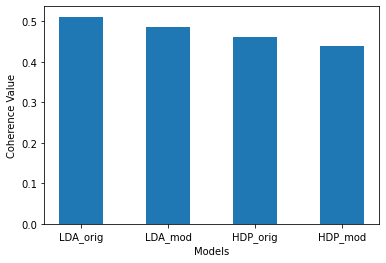

In [18]:
coherences = [coher_lda_orig, coher_lda_mod, coher_hdp_orig, coher_hdp_mod]
model_names = ['LDA_orig', 'LDA_mod', 'HDP_orig', 'HDP_mod']

evaluate_bar_graph(coherences, model_names)

### 5.2 What are the differences in topics for the two dataset versions?

### 5.3 Effect of data size and number of topics on perplexity and coherence scores

In [19]:
def effectOfDataAndK_LDA(datasets, datasetNames, K):
    print("K: ", K)
    print("total Tests: {} datasets * {} values of k = {}".format(str(len(datasets)), str(len(K)), 
                                                                  str(len(datasets) * len(K))))
    perplexityScores = {} 
    coherenceScores = {}
    for datasetName, papers in zip(datasetNames, datasets):
        print("running for dataset ", datasetName)
        data_prep, corpus, dictionary = preprocess(papers)
        
        perplexityForK = {}
        coherenceForK = {}
        for k in K:
            model = tm1(data_prep, k, corpus, dictionary)
            perp_score, coherence_lda = calculate_metrics_lda(data_prep, corpus, dictionary, model)
            
            print("For {} and k = {}: perplexity = {}, coherence = {}".format(datasetName, str(k), 
                                                                              str(perp_score), str(coherence_lda)))
            perplexityForK[str(k)] = perp_score
            coherenceForK[str(k)] = coherence_lda
            
        perplexityScores[datasetName] = perplexityForK
        coherenceScores[datasetName] = coherenceForK
        
    return perplexityScores, coherenceScores

In [20]:
def plot_perplexity(score, data_name):
    
    #plotting perplexity
    %matplotlib inline

    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    K = [i*3 for i in range(1, 11)]
    fig.tight_layout()

    #graph when N is same for all k
    for i in range(len(data_name)):
        perp_scoreDict = score[data_name[i]]
        perp_scores = []
        for numTopics in K:
            perp_scores.append(perp_scoreDict[str(numTopics)])
        
        axes[i].set_xticks(K)
        axes[i].plot(K, perp_scores)
        axes[i].set_xlabel("number of topics (k)")
        axes[i].set_ylabel("log_Perplexity")
        axes[i].set_title(data_name[i])

    plt.tight_layout()
    plt.show()

In [21]:
def plot_coherence(score, data_name):
    
    #plotting perplexity
    %matplotlib inline

    fig, axes = plt.subplots(3, 1, figsize=(15, 10))
    K = [i*3 for i in range(1, 11)]
    fig.tight_layout()

    #graph when N is same for all k
    for i in range(len(data_name)):
        coher_scoreDict = score[data_name[i]]
        coher_scores = []
        for numTopics in K:
            coher_scores.append(coher_scoreDict[str(numTopics)])
        
        axes[i].set_xticks(K)
        axes[i].plot(K, coher_scores)
        axes[i].set_xlabel("number of topics (k)")
        axes[i].set_ylabel("Coherence")
        axes[i].set_title(data_name[i])

    plt.tight_layout()
    plt.show()

#### 5.3.1 Making three datasets with 11998 (60%), 15998 (80%), and 19997(100%) documents

###### Randomly sampling papers

In [22]:
def sample(data, numSamples):
    randomSamples = random.sample(data, numSamples)
    return randomSamples

##### 5.3.1.1 LDA for `papers_orig`

In [23]:
data_original = load_dataset(ARCHIVE_NAME_ORIGINAL)

#sample the data
papers_orig_60 = sample(data_original, 11998)
papers_orig_80 = sample(data_original, 15998)
papers_orig_100 = data_original

Decompressing original.zip
Data is decompressed!


#### Checking the effect of change in 'k' and 'N'

In [24]:
k = [i*3 for i in range(1, 11)]
datasets_paper_orig = [papers_orig_60, papers_orig_80, papers_orig_100]
datasetNames_orig = ["papers_orig_60", "papers_orig_80", "papers_orig_100"]
ldaperp_orig, ldacoher_orig = effectOfDataAndK_LDA(datasets_paper_orig, datasetNames_orig, k)

K:  [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
total Tests: 3 datasets * 10 values of k = 30
running for dataset  papers_orig_60


100%|█████████████████████████████████████████████████████████████████████████| 11996/11996 [00:01<00:00, 10955.60it/s]


Number of unique tokens: 3542
Number of documents - corpus size: 11996
For papers_orig_60 and k = 3: perplexity = -7.207978052044373, coherence = 0.6167373490645672
For papers_orig_60 and k = 6: perplexity = -7.2325391444063145, coherence = 0.5649211874872416
For papers_orig_60 and k = 9: perplexity = -7.226044978921141, coherence = 0.5519459877511346
For papers_orig_60 and k = 12: perplexity = -7.370326523712344, coherence = 0.5009224552523243
For papers_orig_60 and k = 15: perplexity = -9.051569145120617, coherence = 0.491391458980505
For papers_orig_60 and k = 18: perplexity = -9.59260823653772, coherence = 0.4422411615844549
For papers_orig_60 and k = 21: perplexity = -9.91882671028061, coherence = 0.4625799934576394
For papers_orig_60 and k = 24: perplexity = -10.269411872297061, coherence = 0.4678492110873482
For papers_orig_60 and k = 27: perplexity = -10.610506484830907, coherence = 0.46954393037618825
For papers_orig_60 and k = 30: perplexity = -10.945671547372788, coherence =

100%|██████████████████████████████████████████████████████████████████████████| 15996/15996 [00:01<00:00, 8117.85it/s]


Number of unique tokens: 4302
Number of documents - corpus size: 15996
For papers_orig_80 and k = 3: perplexity = -7.319388569631049, coherence = 0.6169758803811698
For papers_orig_80 and k = 6: perplexity = -7.364882414394146, coherence = 0.524250116115067
For papers_orig_80 and k = 9: perplexity = -7.357445192017331, coherence = 0.5149894746253773
For papers_orig_80 and k = 12: perplexity = -7.621303975450971, coherence = 0.5006062054538564
For papers_orig_80 and k = 15: perplexity = -9.655714066078756, coherence = 0.571416889802181
For papers_orig_80 and k = 18: perplexity = -10.261779873290092, coherence = 0.473517449952201
For papers_orig_80 and k = 21: perplexity = -10.672808734128031, coherence = 0.46152789417249046
For papers_orig_80 and k = 24: perplexity = -11.090411811981554, coherence = 0.4600086313944043
For papers_orig_80 and k = 27: perplexity = -11.49376216207321, coherence = 0.48508659400522613
For papers_orig_80 and k = 30: perplexity = -11.95152207711676, coherence =

100%|█████████████████████████████████████████████████████████████████████████| 19995/19995 [00:01<00:00, 10877.74it/s]


Number of unique tokens: 4969
Number of documents - corpus size: 19995
For papers_orig_100 and k = 3: perplexity = -7.397678572102098, coherence = 0.5949672835438852
For papers_orig_100 and k = 6: perplexity = -7.421407928352504, coherence = 0.5391096315930295
For papers_orig_100 and k = 9: perplexity = -7.4121368103831, coherence = 0.5230751312083479
For papers_orig_100 and k = 12: perplexity = -7.785996170732318, coherence = 0.5350353458223338
For papers_orig_100 and k = 15: perplexity = -9.652163487045744, coherence = 0.555662753858648
For papers_orig_100 and k = 18: perplexity = -10.17526571297311, coherence = 0.48559784724834937
For papers_orig_100 and k = 21: perplexity = -10.5525953750882, coherence = 0.4952429720840718
For papers_orig_100 and k = 24: perplexity = -10.937046194853233, coherence = 0.500810134863573
For papers_orig_100 and k = 27: perplexity = -11.324699206937472, coherence = 0.48088436106439997
For papers_orig_100 and k = 30: perplexity = -11.759961151959924, coh

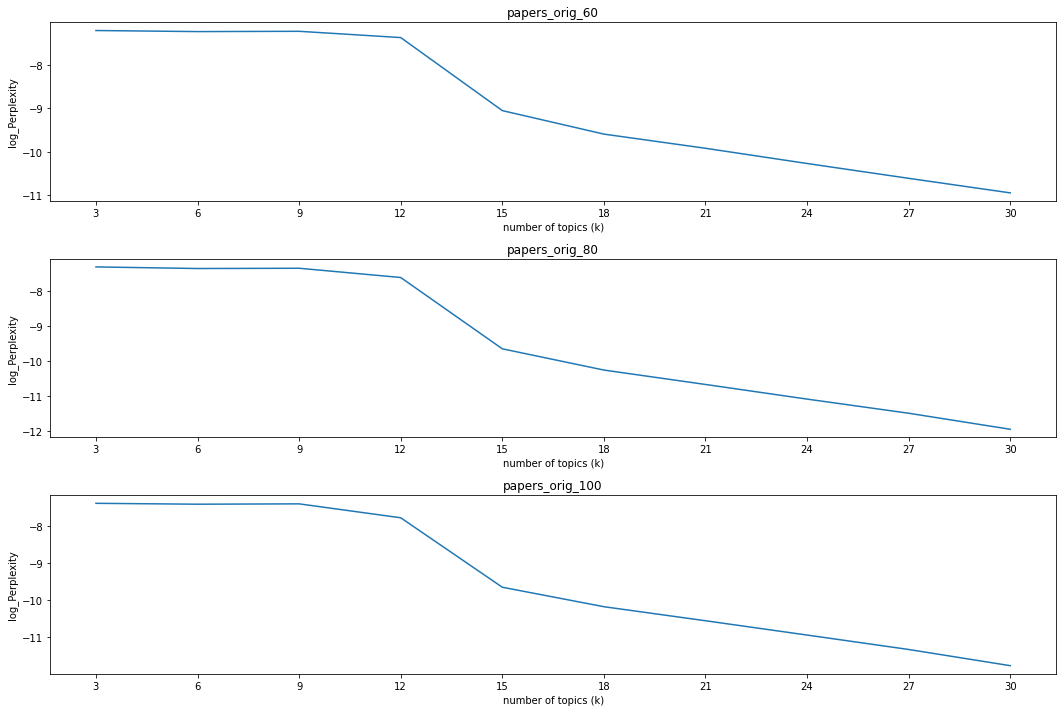

In [25]:
plot_perplexity(ldaperp_orig, datasetNames_orig)

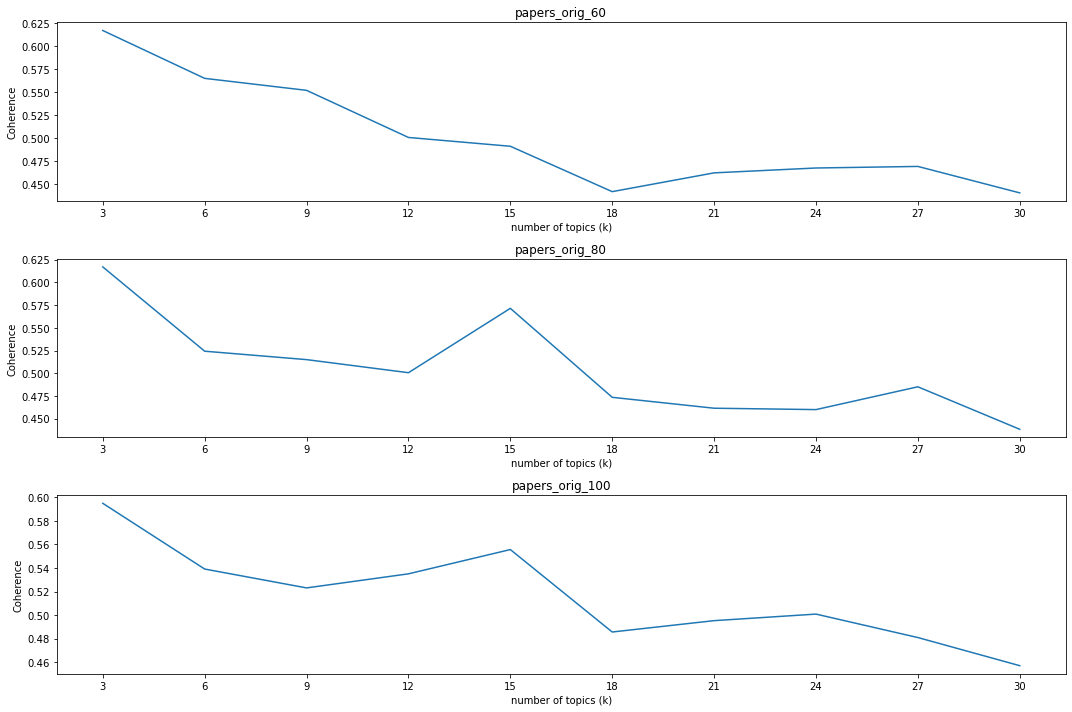

In [26]:
plot_coherence(ldacoher_orig, datasetNames_orig)

##### 5.3.1.2 LDA for `papers_mod`

In [27]:
data_modified = load_dataset(ARCHIVE_NAME_MODIFIED)

#sample the data
papers_mod_60 = sample(data_modified, 11998)
papers_mod_80 = sample(data_modified, 15998)
papers_mod_100 = data_modified

Decompressing modified.zip
Data is decompressed!


In [28]:
k = [i*3 for i in range(1, 11)]
datasets_paper_mod = [papers_mod_60, papers_mod_80, papers_mod_100]
datasetNames_mod = ["papers_mod_60", "papers_mod_80", "papers_mod_100"]
ldaperp_mod, ldacoher_mod = effectOfDataAndK_LDA(datasets_paper_mod, datasetNames_mod, k)

K:  [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
total Tests: 3 datasets * 10 values of k = 30
running for dataset  papers_mod_60


100%|█████████████████████████████████████████████████████████████████████████| 11996/11996 [00:01<00:00, 11012.22it/s]


Number of unique tokens: 3554
Number of documents - corpus size: 11996
For papers_mod_60 and k = 3: perplexity = -7.212027291566428, coherence = 0.5954617568516335
For papers_mod_60 and k = 6: perplexity = -7.246244407976594, coherence = 0.5452315894887863
For papers_mod_60 and k = 9: perplexity = -7.242544959101866, coherence = 0.5305501495382157
For papers_mod_60 and k = 12: perplexity = -7.370387667609135, coherence = 0.4835206949885125
For papers_mod_60 and k = 15: perplexity = -9.204523964520465, coherence = 0.46182078456732434
For papers_mod_60 and k = 18: perplexity = -9.699083024058774, coherence = 0.47771239160834167
For papers_mod_60 and k = 21: perplexity = -10.05381897150097, coherence = 0.4587825523051602
For papers_mod_60 and k = 24: perplexity = -10.405144645907365, coherence = 0.47265355029836514
For papers_mod_60 and k = 27: perplexity = -10.764920363929596, coherence = 0.4611020640486434
For papers_mod_60 and k = 30: perplexity = -11.12321984049668, coherence = 0.4175

100%|█████████████████████████████████████████████████████████████████████████| 15996/15996 [00:01<00:00, 11209.41it/s]


Number of unique tokens: 4312
Number of documents - corpus size: 15996
For papers_mod_80 and k = 3: perplexity = -7.307965995943713, coherence = 0.6212209535157929
For papers_mod_80 and k = 6: perplexity = -7.316572266918889, coherence = 0.5846627472128122
For papers_mod_80 and k = 9: perplexity = -7.326011671805378, coherence = 0.5053559557785198
For papers_mod_80 and k = 12: perplexity = -7.61152654262614, coherence = 0.5118508397127584
For papers_mod_80 and k = 15: perplexity = -9.26972303899959, coherence = 0.5361976612060808
For papers_mod_80 and k = 18: perplexity = -9.621892145206914, coherence = 0.5474025940047399
For papers_mod_80 and k = 21: perplexity = -9.948637917009824, coherence = 0.5376172829190463
For papers_mod_80 and k = 24: perplexity = -10.274054910209786, coherence = 0.5002669414210174
For papers_mod_80 and k = 27: perplexity = -10.60459423120763, coherence = 0.4983767569184414
For papers_mod_80 and k = 30: perplexity = -10.945872526150886, coherence = 0.487772946

100%|█████████████████████████████████████████████████████████████████████████| 18395/18395 [00:01<00:00, 11118.53it/s]


Number of unique tokens: 4695
Number of documents - corpus size: 18395
For papers_mod_100 and k = 3: perplexity = -7.354521928268926, coherence = 0.5971560700137342
For papers_mod_100 and k = 6: perplexity = -7.403106751466165, coherence = 0.5367394293014733
For papers_mod_100 and k = 9: perplexity = -7.395329340368, coherence = 0.5139281066542796
For papers_mod_100 and k = 12: perplexity = -7.822521676012406, coherence = 0.47157643112296893
For papers_mod_100 and k = 15: perplexity = -9.92169583740552, coherence = 0.4875401517070095
For papers_mod_100 and k = 18: perplexity = -10.475523149429115, coherence = 0.5243924638934859
For papers_mod_100 and k = 21: perplexity = -10.918019944589036, coherence = 0.4660079805228601
For papers_mod_100 and k = 24: perplexity = -11.344266622081065, coherence = 0.44836425514186445
For papers_mod_100 and k = 27: perplexity = -11.785568798239094, coherence = 0.431918708727263
For papers_mod_100 and k = 30: perplexity = -12.248374861728413, coherence =

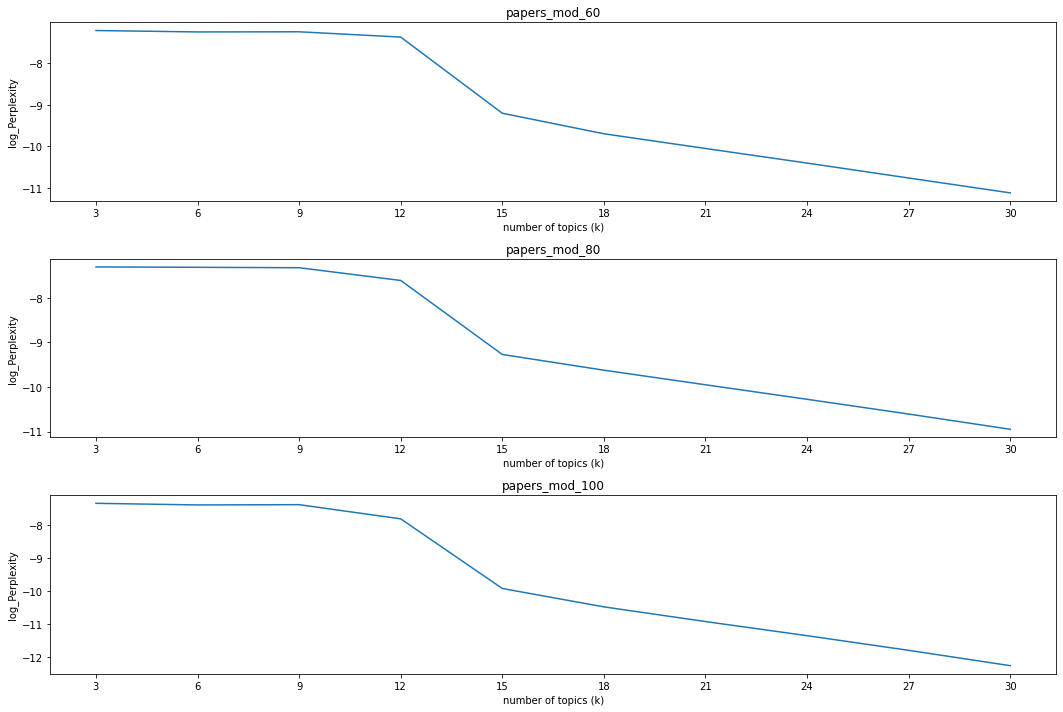

In [30]:
plot_perplexity(ldaperp_mod, datasetNames_mod)

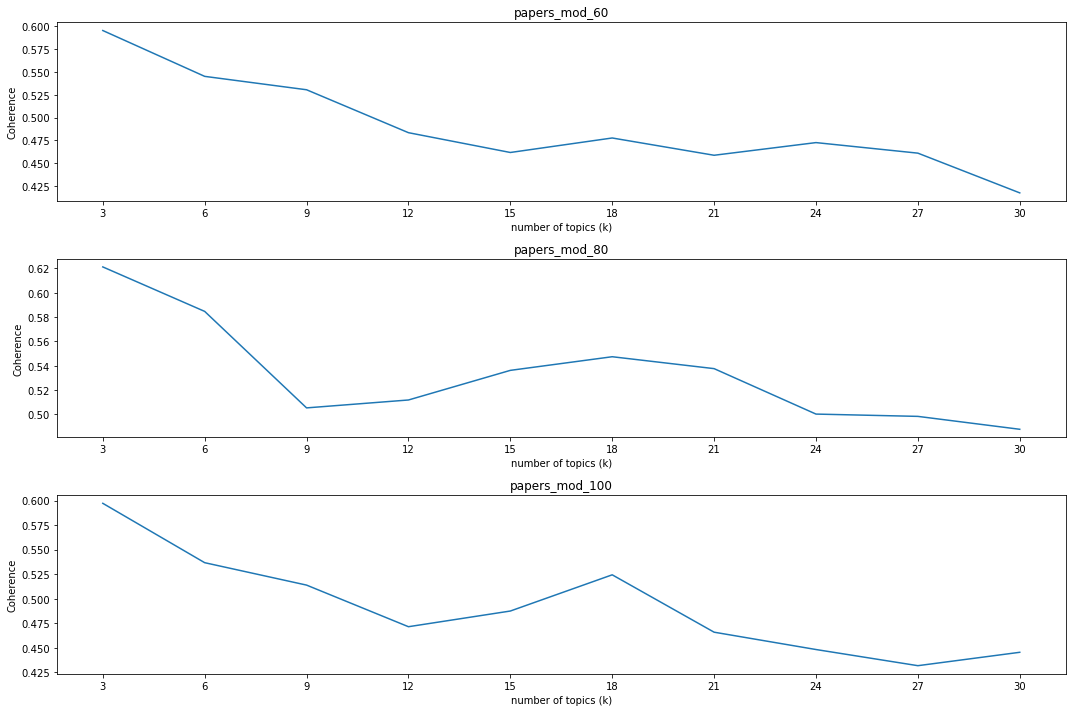

In [31]:
plot_coherence(ldacoher_mod, datasetNames_mod)

##### 5.3.1.3 HDP for `papers_orig`

In [32]:
def effectOfDataAndK_HDP(datasets, datasetNames, K):
    print("K: ", K)
    print("total Tests: {} datasets * {} values of k = {}".format(str(len(datasets)), str(len(K)), 
                                                                  str(len(datasets) * len(K))))
    coherenceScores = {}
    for datasetName, papers in zip(datasetNames, datasets):
        print("running for dataset ", datasetName)
        data_prep, corpus, dictionary = preprocess(papers)
        
        model = tm2(corpus, dictionary)
        hdptopics = [[term for term, wt in model.show_topic(n, topn=10)] for n in range(model.m_T)]
        
        coherenceForK = {}
        for k in K:            
            coherence_hdp = CoherenceModel(
                topics=hdptopics[:k], 
                texts=data_prep, 
                dictionary=dictionary).get_coherence()
            
            print("For {} and k = {}: coherence = {}".format(datasetName, str(k), str(coherence_hdp)))
            coherenceForK[str(k)] = coherence_hdp
            
        coherenceScores[datasetName] = coherenceForK
        
    return coherenceScores

In [33]:
k = [i*3 for i in range(1, 11)]
datasets_paper_orig = [papers_orig_60, papers_orig_80, papers_orig_100]
datasetNames_orig = ["papers_orig_60", "papers_orig_80", "papers_orig_100"]
hdpcoher_orig = effectOfDataAndK_HDP(datasets_paper_orig, datasetNames_orig, k)

K:  [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
total Tests: 3 datasets * 10 values of k = 30
running for dataset  papers_orig_60


100%|█████████████████████████████████████████████████████████████████████████| 11996/11996 [00:01<00:00, 11160.43it/s]


Number of unique tokens: 3542
Number of documents - corpus size: 11996
For papers_orig_60 and k = 3: coherence = 0.7608083098446086
For papers_orig_60 and k = 6: coherence = 0.7221158893641989
For papers_orig_60 and k = 9: coherence = 0.598267701338125
For papers_orig_60 and k = 12: coherence = 0.5202950421114382
For papers_orig_60 and k = 15: coherence = 0.4833476879902419
For papers_orig_60 and k = 18: coherence = 0.4472606124813621
For papers_orig_60 and k = 21: coherence = 0.42717430383426713
For papers_orig_60 and k = 24: coherence = 0.40682974009244094
For papers_orig_60 and k = 27: coherence = 0.39231823601278937
For papers_orig_60 and k = 30: coherence = 0.384914780298042
running for dataset  papers_orig_80


100%|█████████████████████████████████████████████████████████████████████████| 15996/15996 [00:01<00:00, 11583.81it/s]


Number of unique tokens: 4302
Number of documents - corpus size: 15996
For papers_orig_80 and k = 3: coherence = 0.7177215346792618
For papers_orig_80 and k = 6: coherence = 0.784195967576637
For papers_orig_80 and k = 9: coherence = 0.6585756726285578
For papers_orig_80 and k = 12: coherence = 0.571979511711267
For papers_orig_80 and k = 15: coherence = 0.5257823715813211
For papers_orig_80 and k = 18: coherence = 0.48693726232105483
For papers_orig_80 and k = 21: coherence = 0.46926535335515274
For papers_orig_80 and k = 24: coherence = 0.4462058849947848
For papers_orig_80 and k = 27: coherence = 0.4367795680791045
For papers_orig_80 and k = 30: coherence = 0.4234151585667287
running for dataset  papers_orig_100


100%|█████████████████████████████████████████████████████████████████████████| 19995/19995 [00:01<00:00, 11371.55it/s]


Number of unique tokens: 4969
Number of documents - corpus size: 19995
For papers_orig_100 and k = 3: coherence = 0.7523451058859681
For papers_orig_100 and k = 6: coherence = 0.7508719901253192
For papers_orig_100 and k = 9: coherence = 0.6993366242744956
For papers_orig_100 and k = 12: coherence = 0.6066000679126956
For papers_orig_100 and k = 15: coherence = 0.5495491986343747
For papers_orig_100 and k = 18: coherence = 0.5115525236161409
For papers_orig_100 and k = 21: coherence = 0.4827594766654706
For papers_orig_100 and k = 24: coherence = 0.4635746389984572
For papers_orig_100 and k = 27: coherence = 0.44047436487448377
For papers_orig_100 and k = 30: coherence = 0.42743857648952205


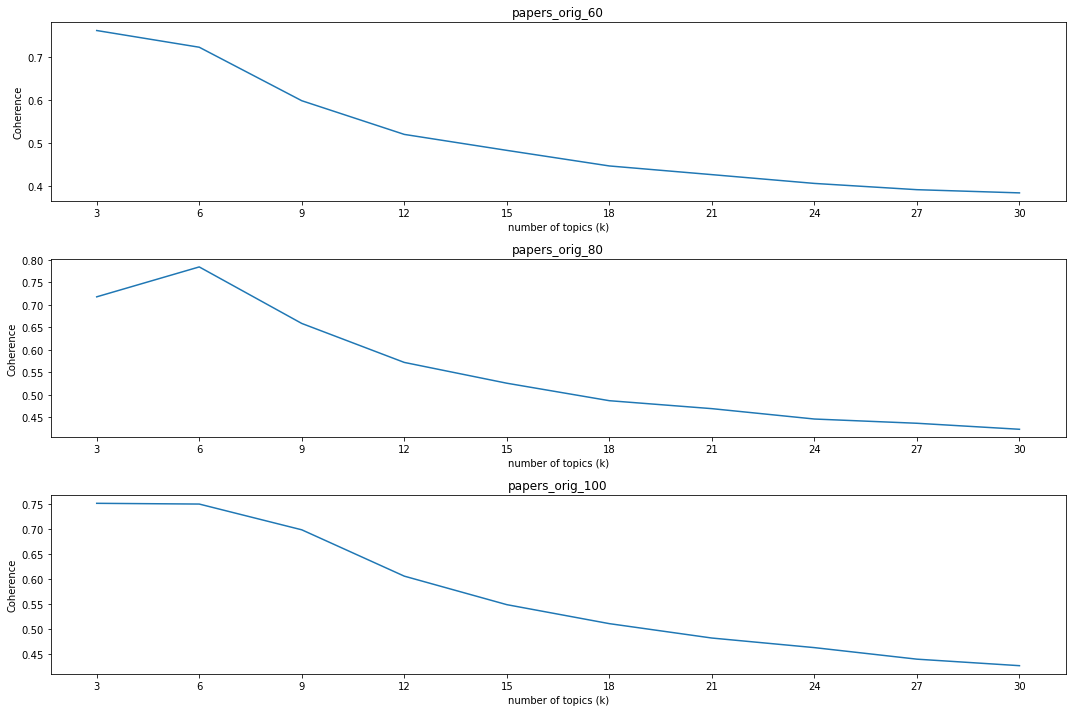

In [34]:
plot_coherence(hdpcoher_orig, datasetNames_orig)

##### 5.3.1.4 HDP for `papers_mod`

In [35]:
k = [i*3 for i in range(1, 11)]
datasets_paper_mod = [papers_mod_60, papers_mod_80, papers_mod_100]
datasetNames_mod = ["papers_mod_60", "papers_mod_80", "papers_mod_100"]
hdpcoher_mod = effectOfDataAndK_HDP(datasets_paper_mod, datasetNames_mod, k)

K:  [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
total Tests: 3 datasets * 10 values of k = 30
running for dataset  papers_mod_60


100%|█████████████████████████████████████████████████████████████████████████| 11996/11996 [00:01<00:00, 11076.22it/s]


Number of unique tokens: 3554
Number of documents - corpus size: 11996
For papers_mod_60 and k = 3: coherence = 0.654679625111264
For papers_mod_60 and k = 6: coherence = 0.6867362596983746
For papers_mod_60 and k = 9: coherence = 0.5612586001483657
For papers_mod_60 and k = 12: coherence = 0.48657462374629395
For papers_mod_60 and k = 15: coherence = 0.4519754870955712
For papers_mod_60 and k = 18: coherence = 0.4181101115678718
For papers_mod_60 and k = 21: coherence = 0.3952096956934105
For papers_mod_60 and k = 24: coherence = 0.38077424286254696
For papers_mod_60 and k = 27: coherence = 0.3689470090094525
For papers_mod_60 and k = 30: coherence = 0.35747203017012386
running for dataset  papers_mod_80


100%|█████████████████████████████████████████████████████████████████████████| 15996/15996 [00:01<00:00, 11231.96it/s]


Number of unique tokens: 4312
Number of documents - corpus size: 15996
For papers_mod_80 and k = 3: coherence = 0.6980551071524586
For papers_mod_80 and k = 6: coherence = 0.7447457753522286
For papers_mod_80 and k = 9: coherence = 0.5883618743544077
For papers_mod_80 and k = 12: coherence = 0.5349574057112844
For papers_mod_80 and k = 15: coherence = 0.48606956675173424
For papers_mod_80 and k = 18: coherence = 0.44846780337551917
For papers_mod_80 and k = 21: coherence = 0.42281764149648604
For papers_mod_80 and k = 24: coherence = 0.41304361896509895
For papers_mod_80 and k = 27: coherence = 0.393042884018163
For papers_mod_80 and k = 30: coherence = 0.3813757081118057
running for dataset  papers_mod_100


100%|█████████████████████████████████████████████████████████████████████████| 18395/18395 [00:01<00:00, 11265.53it/s]


Number of unique tokens: 4695
Number of documents - corpus size: 18395
For papers_mod_100 and k = 3: coherence = 0.6476363523927292
For papers_mod_100 and k = 6: coherence = 0.6583481308706278
For papers_mod_100 and k = 9: coherence = 0.5667364763005548
For papers_mod_100 and k = 12: coherence = 0.4971395696061252
For papers_mod_100 and k = 15: coherence = 0.45058261682230516
For papers_mod_100 and k = 18: coherence = 0.4280348955217602
For papers_mod_100 and k = 21: coherence = 0.4147020143735813
For papers_mod_100 and k = 24: coherence = 0.40046878010732695
For papers_mod_100 and k = 27: coherence = 0.39225103805638056
For papers_mod_100 and k = 30: coherence = 0.388823031844047


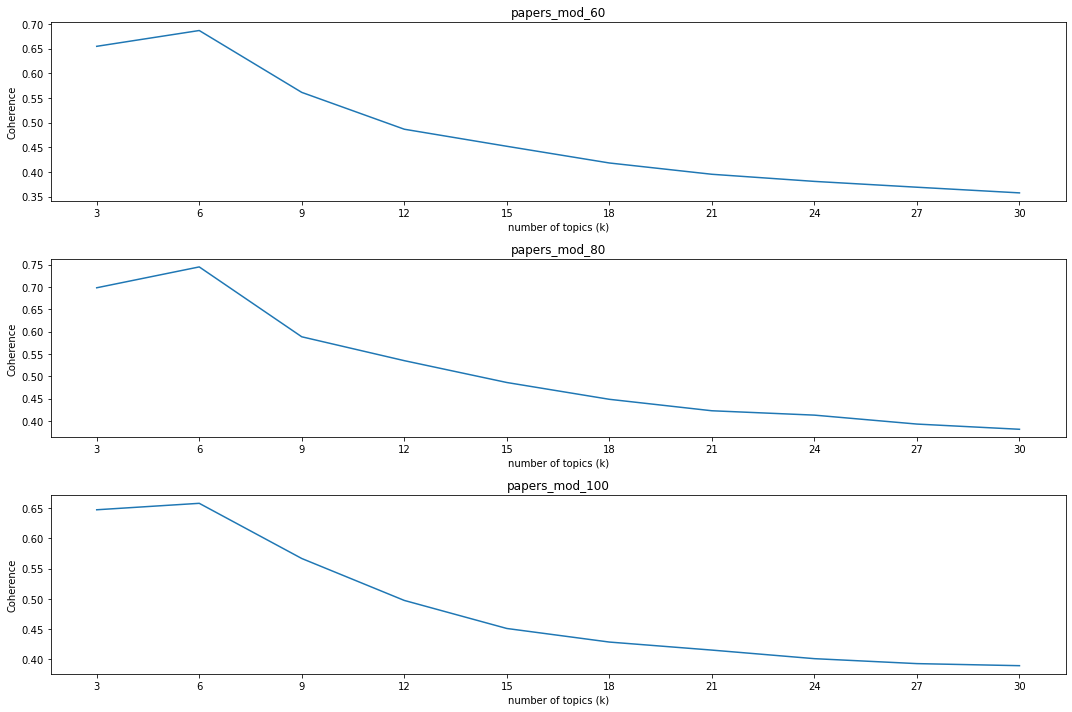

In [36]:
plot_coherence(hdpcoher_mod, datasetNames_mod)

#### 5.3.2 Making three datasets with 500 000, 1 500 000, 2 500 000 sentences

In [37]:
def getSentenceBasedCorpus(data, N):
    # M = 19997 for data_original
    # M = 18397 for data_modified
    #M samples will have N/M number of sentences from each sample
    #get sentences from the data
    
    sentences = [sent_tokenize(paper) for paper in data]
    n = int(N/len(sentences))
    sentenceData = ["".join(i[:n]) for i in sentences if len(i) != 0]
    
    return sentenceData

##### Training LDA and HDP for these sentence-based datasets

##### 5.3.2.1 LDA for `papers_orig`

In [38]:
nltk.download('punkt')

sentences_500000_orig = getSentenceBasedCorpus(data_original, 500000)
sentences_1500000_orig = getSentenceBasedCorpus(data_original, 1500000)
sentences_2500000_orig = getSentenceBasedCorpus(data_original, 2500000)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\User\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [40]:
k = [i*3 for i in range(1, 11)]
datasets_sentence_orig = [sentences_500000_orig, sentences_1500000_orig, sentences_2500000_orig]
datasetNames_sent_orig = ["sent_orig_500000", "sent_orig_1500000", "sent_orig_2500000"]
ldaperp_sent_orig, ldacoher_sent_orig = effectOfDataAndK_LDA(datasets_sentence_orig, datasetNames_sent_orig, k)

K:  [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
total Tests: 3 datasets * 10 values of k = 30
running for dataset  sent_orig_500000


100%|█████████████████████████████████████████████████████████████████████████| 19995/19995 [00:01<00:00, 10548.93it/s]


Number of unique tokens: 4384
Number of documents - corpus size: 19995
For sent_orig_500000 and k = 3: perplexity = -7.258513759424878, coherence = 0.6290138642467099
For sent_orig_500000 and k = 6: perplexity = -7.3159123982074155, coherence = 0.49706955670132147
For sent_orig_500000 and k = 9: perplexity = -7.314434880859255, coherence = 0.48535960584025734
For sent_orig_500000 and k = 12: perplexity = -7.629624749668753, coherence = 0.44310614940506515
For sent_orig_500000 and k = 15: perplexity = -9.71640165209094, coherence = 0.49267913807151786
For sent_orig_500000 and k = 18: perplexity = -10.264217027951968, coherence = 0.4685826981462095
For sent_orig_500000 and k = 21: perplexity = -10.686345427961204, coherence = 0.44162256492239554
For sent_orig_500000 and k = 24: perplexity = -11.100398690757226, coherence = 0.4435039370340033
For sent_orig_500000 and k = 27: perplexity = -11.542638933235308, coherence = 0.44456769718458866
For sent_orig_500000 and k = 30: perplexity = -11

100%|█████████████████████████████████████████████████████████████████████████| 19995/19995 [00:01<00:00, 13114.53it/s]


Number of unique tokens: 4718
Number of documents - corpus size: 19995
For sent_orig_1500000 and k = 3: perplexity = -7.336099401708247, coherence = 0.6301227185295564
For sent_orig_1500000 and k = 6: perplexity = -7.364420612554617, coherence = 0.5605990413882855
For sent_orig_1500000 and k = 9: perplexity = -7.371717793523959, coherence = 0.5015724121370341
For sent_orig_1500000 and k = 12: perplexity = -7.7562033487787545, coherence = 0.48705099402050617
For sent_orig_1500000 and k = 15: perplexity = -9.787254577461626, coherence = 0.501585066283797
For sent_orig_1500000 and k = 18: perplexity = -10.324406254470658, coherence = 0.45358396158259473
For sent_orig_1500000 and k = 21: perplexity = -10.744814409270665, coherence = 0.4633234246949012
For sent_orig_1500000 and k = 24: perplexity = -11.174482244505114, coherence = 0.44483766955729404
For sent_orig_1500000 and k = 27: perplexity = -11.59386219256851, coherence = 0.44874858951660435
For sent_orig_1500000 and k = 30: perplexit

100%|█████████████████████████████████████████████████████████████████████████| 19995/19995 [00:01<00:00, 10943.84it/s]


Number of unique tokens: 4829
Number of documents - corpus size: 19995
For sent_orig_2500000 and k = 3: perplexity = -7.373868039442456, coherence = 0.5928931475005639
For sent_orig_2500000 and k = 6: perplexity = -7.389067500173834, coherence = 0.5891699269198031
For sent_orig_2500000 and k = 9: perplexity = -7.393834619552147, coherence = 0.48285525503336924
For sent_orig_2500000 and k = 12: perplexity = -7.755336737087694, coherence = 0.4931430996291603
For sent_orig_2500000 and k = 15: perplexity = -9.799736726830515, coherence = 0.50524917769683
For sent_orig_2500000 and k = 18: perplexity = -10.346416551022966, coherence = 0.502111616503705
For sent_orig_2500000 and k = 21: perplexity = -10.760008628521748, coherence = 0.4906272971884376
For sent_orig_2500000 and k = 24: perplexity = -11.189091930827793, coherence = 0.45261248710742535
For sent_orig_2500000 and k = 27: perplexity = -11.594014453524045, coherence = 0.4898948926659736
For sent_orig_2500000 and k = 30: perplexity = 

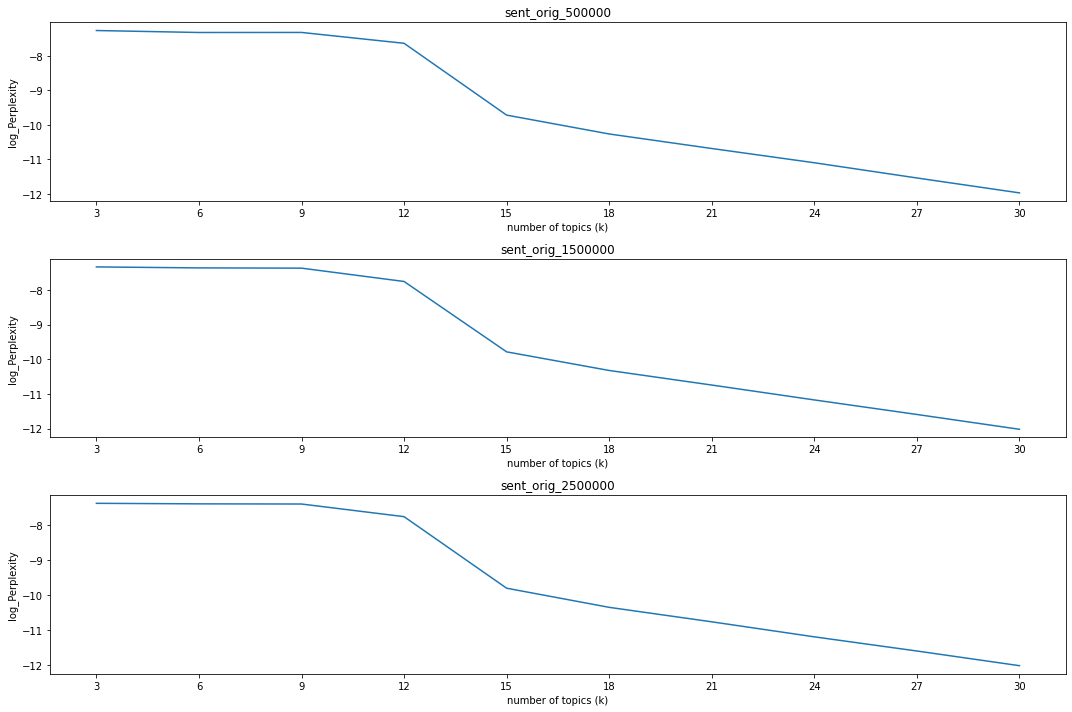

In [41]:
plot_perplexity(ldaperp_sent_orig, datasetNames_sent_orig)

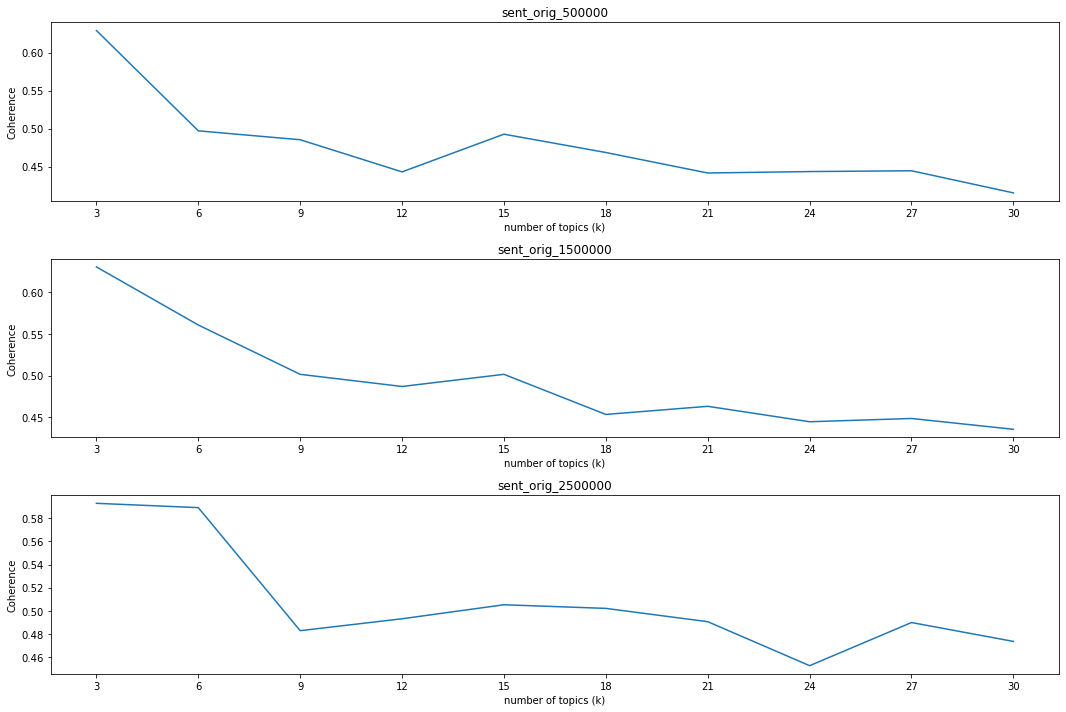

In [42]:
plot_coherence(ldacoher_sent_orig, datasetNames_sent_orig)

##### 5.3.2.2 LDA for `papers_mod`

In [43]:
nltk.download('punkt')

sentences_500000_mod = getSentenceBasedCorpus(data_modified, 500000)
sentences_1500000_mod = getSentenceBasedCorpus(data_modified, 1500000)
sentences_2500000_mod = getSentenceBasedCorpus(data_modified, 2500000)

[nltk_data] Error loading punkt: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


In [45]:
k = [i*3 for i in range(1, 11)]
datasets_sentence_mod = [sentences_500000_mod, sentences_1500000_mod, sentences_2500000_mod]
datasetNames_sent_mod = ["sent_mod_500000", "sent_mod_1500000", "sent_mod_2500000"]
ldaperp_sent_mod, ldacoher_sent_mod = effectOfDataAndK_LDA(datasets_sentence_mod, datasetNames_sent_mod, k)

K:  [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
total Tests: 3 datasets * 10 values of k = 30
running for dataset  sent_mod_500000


100%|██████████████████████████████████████████████████████████████████████████| 18395/18395 [00:02<00:00, 8850.96it/s]


Number of unique tokens: 4167
Number of documents - corpus size: 18395
For sent_mod_500000 and k = 3: perplexity = -7.227931996433865, coherence = 0.6272520742170532
For sent_mod_500000 and k = 6: perplexity = -7.280431839131413, coherence = 0.5620587520730905
For sent_mod_500000 and k = 9: perplexity = -7.278855748662327, coherence = 0.5245223619261101
For sent_mod_500000 and k = 12: perplexity = -7.5816228481647086, coherence = 0.4851075369365277
For sent_mod_500000 and k = 15: perplexity = -9.614082225842042, coherence = 0.5303247760359959
For sent_mod_500000 and k = 18: perplexity = -10.145770640572975, coherence = 0.4525446829813464
For sent_mod_500000 and k = 21: perplexity = -10.560210049861386, coherence = 0.45770471168063703
For sent_mod_500000 and k = 24: perplexity = -10.977685600791562, coherence = 0.46686224264994
For sent_mod_500000 and k = 27: perplexity = -11.383051925226562, coherence = 0.4344344933770905
For sent_mod_500000 and k = 30: perplexity = -11.815796946442621

100%|██████████████████████████████████████████████████████████████████████████| 18395/18395 [00:02<00:00, 7936.15it/s]


Number of unique tokens: 4485
Number of documents - corpus size: 18395
For sent_mod_1500000 and k = 3: perplexity = -7.305323743689059, coherence = 0.6146426985228759
For sent_mod_1500000 and k = 6: perplexity = -7.348425494432884, coherence = 0.5524458729719889
For sent_mod_1500000 and k = 9: perplexity = -7.351914845936294, coherence = 0.5120564008278143
For sent_mod_1500000 and k = 12: perplexity = -7.675612237009222, coherence = 0.5036901317402226
For sent_mod_1500000 and k = 15: perplexity = -9.762891524491849, coherence = 0.5022509209705517
For sent_mod_1500000 and k = 18: perplexity = -10.336507977971685, coherence = 0.4653324831816243
For sent_mod_1500000 and k = 21: perplexity = -10.763961053835471, coherence = 0.45776591690698976
For sent_mod_1500000 and k = 24: perplexity = -11.197729045720797, coherence = 0.44029833240523053
For sent_mod_1500000 and k = 27: perplexity = -11.63083989446633, coherence = 0.4494456997330985
For sent_mod_1500000 and k = 30: perplexity = -12.0680

100%|█████████████████████████████████████████████████████████████████████████| 18395/18395 [00:01<00:00, 11796.39it/s]


Number of unique tokens: 4566
Number of documents - corpus size: 18395
For sent_mod_2500000 and k = 3: perplexity = -7.33462403665829, coherence = 0.6271833169840234
For sent_mod_2500000 and k = 6: perplexity = -7.356859724203151, coherence = 0.5521135892934242
For sent_mod_2500000 and k = 9: perplexity = -7.3514267171947365, coherence = 0.5050961970532233
For sent_mod_2500000 and k = 12: perplexity = -7.68904787403591, coherence = 0.536892707563363
For sent_mod_2500000 and k = 15: perplexity = -9.86513675551235, coherence = 0.5143664903382579
For sent_mod_2500000 and k = 18: perplexity = -10.390243521642214, coherence = 0.49494256241503937
For sent_mod_2500000 and k = 21: perplexity = -10.807439699247452, coherence = 0.5281940087014807
For sent_mod_2500000 and k = 24: perplexity = -11.23746741547807, coherence = 0.4695942626376815
For sent_mod_2500000 and k = 27: perplexity = -11.678817451494576, coherence = 0.4211547717939367
For sent_mod_2500000 and k = 30: perplexity = -12.13071591

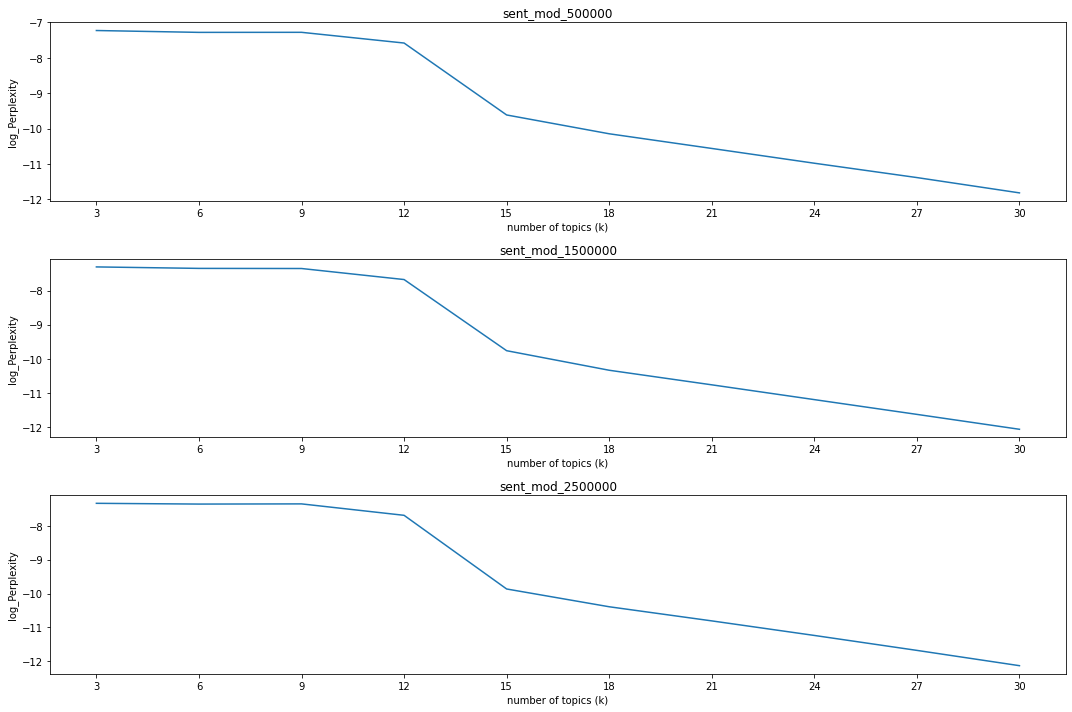

In [46]:
plot_perplexity(ldaperp_sent_mod, datasetNames_sent_mod)

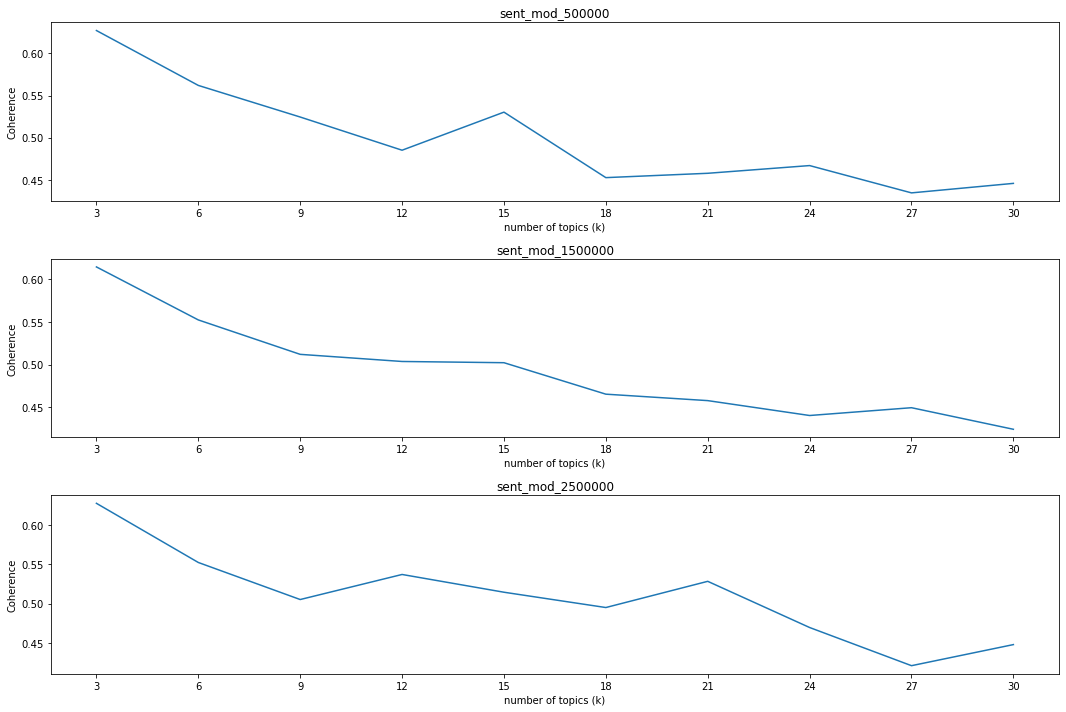

In [47]:
plot_coherence(ldacoher_sent_mod, datasetNames_sent_mod)

##### 5.3.2.3 HDP for `papers_orig`

In [48]:
k = [i*3 for i in range(1, 11)]
datasets_sentence_orig = [sentences_500000_orig, sentences_1500000_orig, sentences_2500000_orig]
datasetNames_sent_orig = ["sent_orig_500000", "sent_orig_1500000", "sent_orig_2500000"]
hdpcoher_sent_orig = effectOfDataAndK_HDP(datasets_sentence_orig, datasetNames_sent_orig, k)

K:  [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
total Tests: 3 datasets * 10 values of k = 30
running for dataset  sent_orig_500000


100%|█████████████████████████████████████████████████████████████████████████| 19995/19995 [00:01<00:00, 14120.67it/s]


Number of unique tokens: 4384
Number of documents - corpus size: 19995
For sent_orig_500000 and k = 3: coherence = 0.8185692168451584
For sent_orig_500000 and k = 6: coherence = 0.7703118108474206
For sent_orig_500000 and k = 9: coherence = 0.6113477563451855
For sent_orig_500000 and k = 12: coherence = 0.5393501197297119
For sent_orig_500000 and k = 15: coherence = 0.5047442440923405
For sent_orig_500000 and k = 18: coherence = 0.4704668989744718
For sent_orig_500000 and k = 21: coherence = 0.4477048714709814
For sent_orig_500000 and k = 24: coherence = 0.4340654399691668
For sent_orig_500000 and k = 27: coherence = 0.4295737734270033
For sent_orig_500000 and k = 30: coherence = 0.4227150898634324
running for dataset  sent_orig_1500000


100%|█████████████████████████████████████████████████████████████████████████| 19995/19995 [00:01<00:00, 12781.41it/s]


Number of unique tokens: 4718
Number of documents - corpus size: 19995
For sent_orig_1500000 and k = 3: coherence = 0.7984818518983815
For sent_orig_1500000 and k = 6: coherence = 0.761078724957806
For sent_orig_1500000 and k = 9: coherence = 0.7706486191164065
For sent_orig_1500000 and k = 12: coherence = 0.6504330648917122
For sent_orig_1500000 and k = 15: coherence = 0.5739883754466818
For sent_orig_1500000 and k = 18: coherence = 0.5269929881206097
For sent_orig_1500000 and k = 21: coherence = 0.49775484988115243
For sent_orig_1500000 and k = 24: coherence = 0.48024403812179456
For sent_orig_1500000 and k = 27: coherence = 0.45899818968624145
For sent_orig_1500000 and k = 30: coherence = 0.4424952930521922
running for dataset  sent_orig_2500000


100%|█████████████████████████████████████████████████████████████████████████| 19995/19995 [00:01<00:00, 11959.69it/s]


Number of unique tokens: 4829
Number of documents - corpus size: 19995
For sent_orig_2500000 and k = 3: coherence = 0.7579818840649631
For sent_orig_2500000 and k = 6: coherence = 0.6639897583982842
For sent_orig_2500000 and k = 9: coherence = 0.5948167430615464
For sent_orig_2500000 and k = 12: coherence = 0.5145301754227272
For sent_orig_2500000 and k = 15: coherence = 0.47421982963526316
For sent_orig_2500000 and k = 18: coherence = 0.45460052409277363
For sent_orig_2500000 and k = 21: coherence = 0.43359767495085694
For sent_orig_2500000 and k = 24: coherence = 0.42103182831404035
For sent_orig_2500000 and k = 27: coherence = 0.41794308833796195
For sent_orig_2500000 and k = 30: coherence = 0.40724641275796175


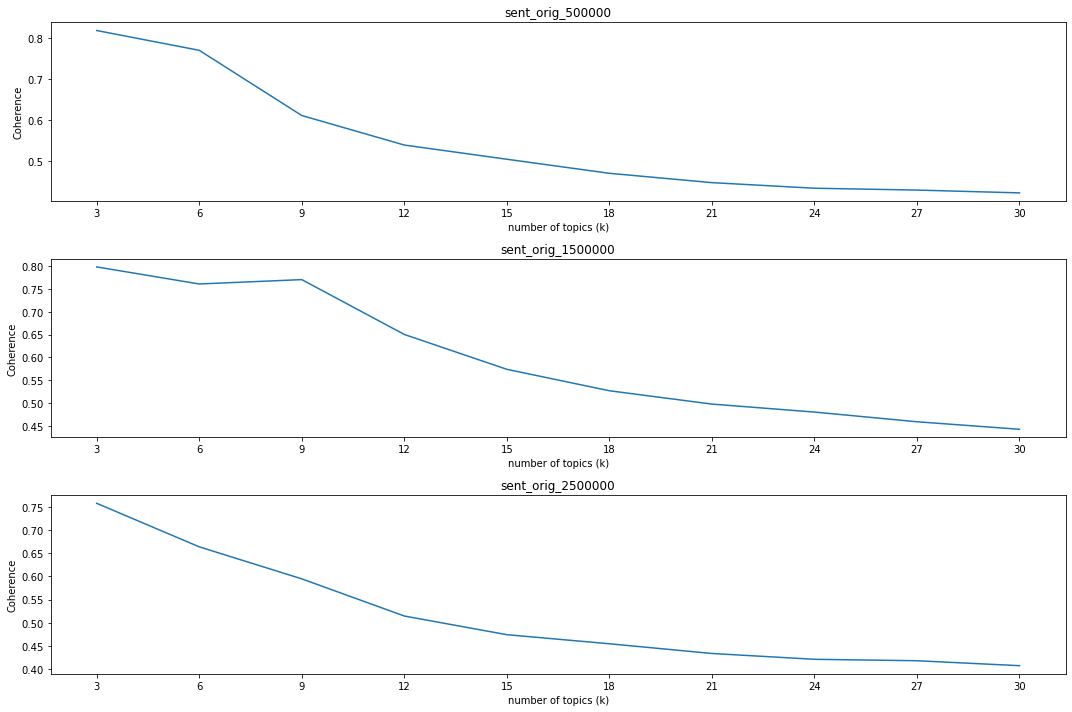

In [49]:
plot_coherence(hdpcoher_sent_orig, datasetNames_sent_orig)

##### 5.3.2.4 HDP for `papers_mod`

In [50]:
k = [i*3 for i in range(1, 11)]
datasets_sentence_mod = [sentences_500000_mod, sentences_1500000_mod, sentences_2500000_mod]
datasetNames_sent_mod = ["sent_mod_500000", "sent_mod_1500000", "sent_mod_2500000"]
hdpcoher_sent_mod = effectOfDataAndK_HDP(datasets_sentence_mod, datasetNames_sent_mod, k)

K:  [3, 6, 9, 12, 15, 18, 21, 24, 27, 30]
total Tests: 3 datasets * 10 values of k = 30
running for dataset  sent_mod_500000


100%|█████████████████████████████████████████████████████████████████████████| 18395/18395 [00:01<00:00, 13768.14it/s]


Number of unique tokens: 4167
Number of documents - corpus size: 18395
For sent_mod_500000 and k = 3: coherence = 0.7127868940807014
For sent_mod_500000 and k = 6: coherence = 0.7128667713561075
For sent_mod_500000 and k = 9: coherence = 0.6746177594619183
For sent_mod_500000 and k = 12: coherence = 0.5979721001918241
For sent_mod_500000 and k = 15: coherence = 0.5404063963037233
For sent_mod_500000 and k = 18: coherence = 0.49757134929430613
For sent_mod_500000 and k = 21: coherence = 0.47264042161221814
For sent_mod_500000 and k = 24: coherence = 0.4591466515765695
For sent_mod_500000 and k = 27: coherence = 0.4455054816154951
For sent_mod_500000 and k = 30: coherence = 0.4387535273858965
running for dataset  sent_mod_1500000


100%|█████████████████████████████████████████████████████████████████████████| 18395/18395 [00:01<00:00, 12637.32it/s]


Number of unique tokens: 4485
Number of documents - corpus size: 18395
For sent_mod_1500000 and k = 3: coherence = 0.7189823294368831
For sent_mod_1500000 and k = 6: coherence = 0.7321978216750266
For sent_mod_1500000 and k = 9: coherence = 0.6060148524142728
For sent_mod_1500000 and k = 12: coherence = 0.5283753834580607
For sent_mod_1500000 and k = 15: coherence = 0.4959581699188881
For sent_mod_1500000 and k = 18: coherence = 0.4629679228342327
For sent_mod_1500000 and k = 21: coherence = 0.4510117844049398
For sent_mod_1500000 and k = 24: coherence = 0.4315087097068549
For sent_mod_1500000 and k = 27: coherence = 0.41710287459115397
For sent_mod_1500000 and k = 30: coherence = 0.4044647945412413
running for dataset  sent_mod_2500000


100%|██████████████████████████████████████████████████████████████████████████| 18395/18395 [00:02<00:00, 7624.04it/s]


Number of unique tokens: 4566
Number of documents - corpus size: 18395
For sent_mod_2500000 and k = 3: coherence = 0.6916453778285169
For sent_mod_2500000 and k = 6: coherence = 0.7383344624799907
For sent_mod_2500000 and k = 9: coherence = 0.5922470777117335
For sent_mod_2500000 and k = 12: coherence = 0.5169732172315489
For sent_mod_2500000 and k = 15: coherence = 0.47213546393357775
For sent_mod_2500000 and k = 18: coherence = 0.4435027117484718
For sent_mod_2500000 and k = 21: coherence = 0.4244306353826586
For sent_mod_2500000 and k = 24: coherence = 0.4072906902890871
For sent_mod_2500000 and k = 27: coherence = 0.4049491311443045
For sent_mod_2500000 and k = 30: coherence = 0.39981689172714235


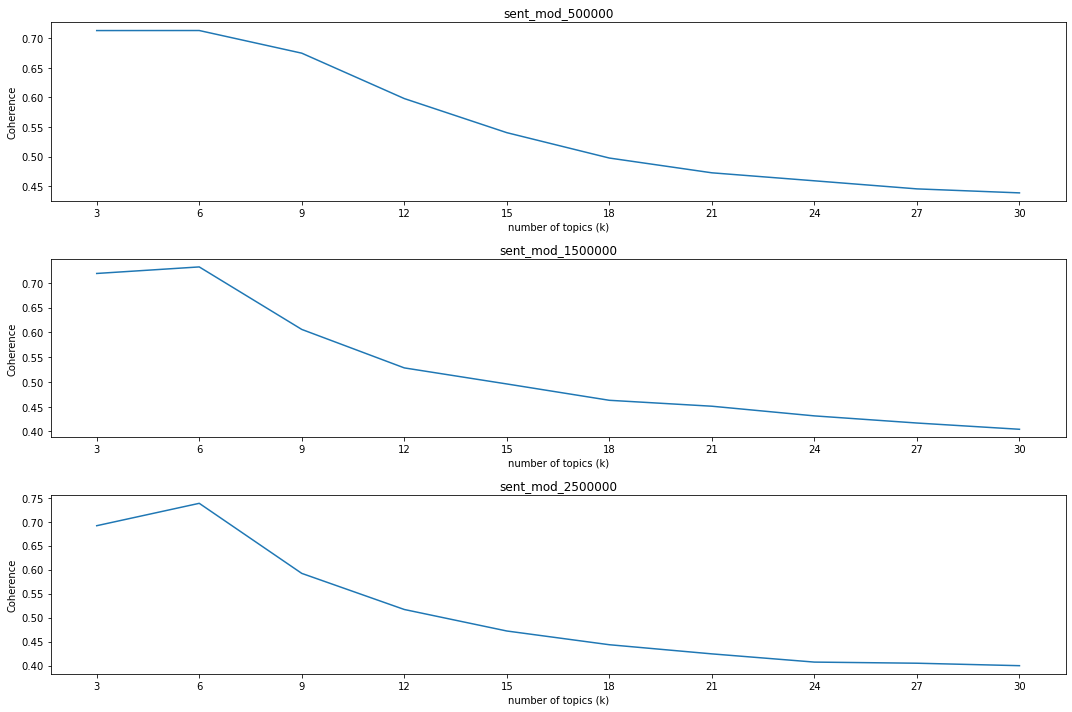

In [51]:
plot_coherence(hdpcoher_sent_mod, datasetNames_sent_mod)

## 6. Further improvements

In [52]:
def effectOfAlphaAndEta_LDA(papers):
    data_prep, corpus, dictionary = preprocess(papers)

    # Set training parameters.
    num_topics = 20
    chunksize = 100
    passes = 20
    iterations = 1000
    random_state = 0
    alpha=[0.01, 0.05, 0.1, 0.25, 1.0, 5.0]
    eta=[0.01, 0.05, 0.1]
    eval_every = None  # Don't evaluate model perplexity, takes too much time.

    # Make an index to word dictionary.
    temp = dictionary[0]  # This is only to "load" the dictionary.
    id2word = dictionary.id2token
    
    perplexityScores = {} 
    coherenceScores = {}
    for a in alpha:
        perplexityForEta = {}
        coherenceForEta = {}
        for b in eta:
            model = LdaModel(
                corpus=corpus,
                id2word=id2word,
                chunksize=chunksize,
                alpha=a,
                eta=b,
                iterations=iterations,
                num_topics=num_topics,
                passes=passes,
                random_state=random_state,
                eval_every=eval_every
            )
            
            perp_score, coherence_lda = calculate_metrics_lda(data_prep, corpus, dictionary, model)
            
            print("For alpha = {} and eta = {}: perplexity = {}, coherence = {}".format(str(a), str(b),
                                                                                        perp_score, coherence_lda))
            perplexityForEta[str(b)] = perp_score
            coherenceForEta[str(b)] = coherence_lda
        
        perplexityScores[str(a)] = perplexityForEta
        coherenceScores[str(a)] = coherenceForEta
    
    return perplexityScores, coherenceScores 

In [53]:
ldaperp, ldacoher = effectOfAlphaAndEta_LDA(data_modified)

100%|██████████████████████████████████████████████████████████████████████████| 18395/18395 [00:01<00:00, 9593.05it/s]


Number of unique tokens: 4695
Number of documents - corpus size: 18395
For alpha = 0.01 and eta = 0.01: perplexity = -23.2159351232453, coherence = 0.5022697251070242
For alpha = 0.01 and eta = 0.05: perplexity = -10.927836554512906, coherence = 0.5031386303072563
For alpha = 0.01 and eta = 0.1: perplexity = -7.564379663938004, coherence = 0.47857039750546837
For alpha = 0.05 and eta = 0.01: perplexity = -23.136913262054147, coherence = 0.49712862931719987
For alpha = 0.05 and eta = 0.05: perplexity = -10.84623568955246, coherence = 0.4964790539308247
For alpha = 0.05 and eta = 0.1: perplexity = -7.464071516303009, coherence = 0.4722225284709845
For alpha = 0.1 and eta = 0.01: perplexity = -23.114620494390348, coherence = 0.4981873950714588
For alpha = 0.1 and eta = 0.05: perplexity = -10.821456973077936, coherence = 0.48700013763220457
For alpha = 0.1 and eta = 0.1: perplexity = -7.432986642759976, coherence = 0.4878946423429067
For alpha = 0.25 and eta = 0.01: perplexity = -23.067280